A controlled trial of two nucleoside analogues plus indinavir in persons with human immunodeficiency virus infection and CD4 cell counts of 200 per cubic millimeter or less. The New England Journal of Medicine, 1997. https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sksurv.util import Surv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sksurv.metrics import integrated_brier_score
from sklearn.compose import make_column_selector, ColumnTransformer
from sksurv.ensemble import RandomSurvivalForest
from SurvSet.data import SurvLoader

import src

SEED = 1234
np.random.seed(SEED)

In [2]:
loader = SurvLoader()
enc_num = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
sel_num = make_column_selector(pattern='^num\\_')
enc_df = ColumnTransformer(transformers=[('s', enc_num, sel_num)])
enc_df.set_output(transform='pandas')

,transformers,"[('s', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [ ]:
df = loader.load_dataset(ds_name="actg")['df'].set_index("pid")
senc = Surv()
So = senc.from_arrays(df['event'].astype(bool), df['time'])
enc_df.fit(df)
X_train = enc_df.transform(df)
X_train = X_train.loc[:, X_train.columns.str.startswith("s__num_")]
X_train.columns = X_train.columns.str.replace("s__num_", "")

Visualize the 4 numerical features w.r.t. the random treatment.

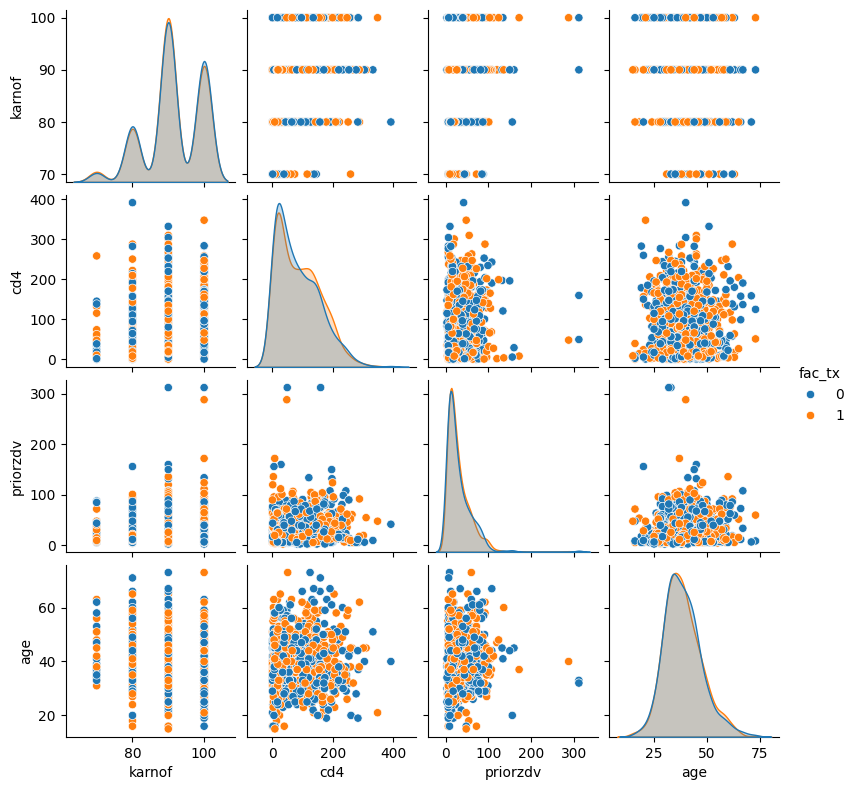

In [36]:
sns.pairplot(pd.concat([X_train, df.fac_tx], axis=1), hue="fac_tx", height=2)

In [33]:
model = RandomSurvivalForest(max_depth=6, n_estimators=300, oob_score=True, random_state=SEED)
model.fit(X=X_train.values, y=So)
print(f'train score: {model.score(X_train.values, So):.04f} | OOB score: {model.oob_score_:.04f}')

train score: 0.9139 | OOB score: 0.7234


In [38]:
np.random.seed(SEED)
n_samples = 200
if X_train.shape[0] > n_samples:
    X_explain = X_train.sample(n_samples)
else:
    n_samples = X_train.shape[0]
    X_explain = X_train
explanations_order2 = src.survshapiq(
    model, 
    X_train.values, 
    [X_explain.iloc[[i]] for i in range(0, X_explain.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="k-SII",
    approximator="auto",
    max_order=2
)

100%|██████████| 200/200 [49:38<00:00, 14.89s/it]


In [42]:
filename = f'results/actg_explanations_order2.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order2, f)

In [43]:
np.random.seed(SEED)
n_samples = 200
if X_train.shape[0] > n_samples:
    X_explain = X_train.sample(n_samples)
else:
    n_samples = X_train.shape[0]
    X_explain = X_train
explanations_order1 = src.survshapiq(
    model, 
    X_train.values, 
    [X_explain.iloc[[i]] for i in range(0, X_explain.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="SV",
    approximator="auto",
    max_order=1
)

100%|██████████| 200/200 [51:57<00:00, 15.59s/it]


In [44]:
filename = f'results/actg_explanations_order1.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order1, f)

In [48]:
CBF_COLORS = [
    "#0072B2", "#E69F00", "#009E73", "#D55E00",
    "#CC79A7", "#F0E442", "#56B4E9", "#999999"
]

### Order 1

In [252]:
timepoints = src.get_evenly_spaced_integers(model.unique_times_, 41)

In [346]:
filename = f'results/actg_explanations_order1.pkl'
with open(filename, 'rb') as f:
    explanations_order1 = pickle.load(f)

In [347]:
df_plot1 = pd.concat([explanations_order1[i].assign(time=timepoints, id=i).iloc[:35,:] for i in range(200)])
df_plot1 = pd.melt(df_plot1, id_vars=['time', 'id'], var_name="feature") #, 'treatment'])
df_plot1 = df_plot1.assign(color=pd.concat([X_explain.iloc[:, i].repeat(35) for i in range(4)]).values)

General plot

In [ ]:
ax = sns.relplot(
    df_plot1, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2.25,
    aspect=1,
    col_wrap=4
    # hue="treatment", palette=sns.color_palette("tab10")
)
ax.set(ylim=(-0.2, 0.1))
# ax.fig.suptitle("SurvSHAP(t) values explaining a random forest predicting survival of patients treating the HIV-1 infection", y=0.95)
# sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
# plt.title(f'')
ax.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.savefig(f'results/actg_order1_global.png', bbox_inches="tight")
# plt.clf()

Detailed plots

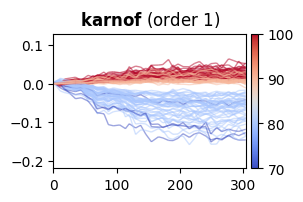

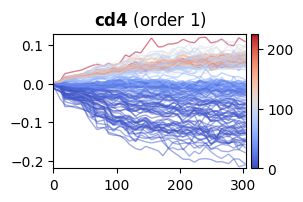

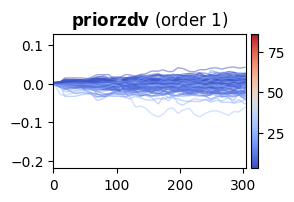

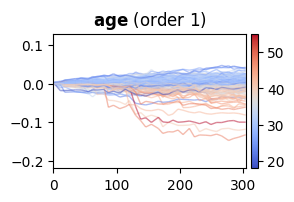

In [601]:
for feature_name in df_plot1.feature.unique():
    temp = df_plot1[df_plot1.feature == feature_name]
    fig, ax = plt.subplots(figsize=(3, 1.75))

    CMAP = "coolwarm"

    for id_val in temp.id.unique():
        line_data = temp[temp.id == id_val].sort_values(by="time")
        x = line_data["time"].values
        y = line_data["value"].values
        c = line_data["color"].values

        # Create line segments with color
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(
            segments,
            cmap=CMAP, # coolwarm
            norm=plt.Normalize(temp.color.min(), temp.color.max()),
            array=c[:-1],  # color values
            linewidth=1,
            alpha=0.5
        )
        ax.add_collection(lc)

    ax.set_xlim(0, 305)
    ax.set_ylim(-0.22, 0.13)
    ax.set_title("$\mathbf{" + feature_name + "}$ (order 1)")
    # if feature_name == "age":
    #     ax.set_xlabel('Time')
    #     ax.set_ylabel(' ')
    # if feature_name == "karnof":
    #     ax.set_xlabel('')
    #     ax.set_ylabel('Attribution')
    # if feature_name == "priorzdv":
    #     ax.set_xlabel(' ')
    #     ax.set_ylabel(' ')
    # if feature_name == "cd4":
    #     ax.set_xlabel('Time')
    #     ax.set_ylabel('Attribution')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(temp.color.quantile(0.00), temp.color.quantile(0.95), clip=True))
    sm.set_array([])  # required for colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    # cbar.set_label("color value")
    # plt.tight_layout()
    plt.savefig(f'results/actg_order1_global_{feature_name}.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()

### Order 2

In [ ]:
df_plot2 = pd.concat([explanations_order2[i].assign(time=timepoints, id=i, ).iloc[:35,:] for i in range(200)])
df_plot2 = pd.melt(df_plot2, id_vars=['time', 'id'], var_name="feature") #, 'treatment'])

In [417]:
df_plot2_attribution = df_plot2.loc[df_plot2.feature.isin(['karnof', 'cd4', 'priorzdv', 'age']), :]
df_plot2_attribution = df_plot2_attribution.assign(color=pd.concat([X_explain.iloc[:, i].repeat(35) for i in range(4)]).values)

In [420]:
df_plot2_interaction = df_plot2.loc[~df_plot2.feature.isin(['karnof', 'cd4', 'priorzdv', 'age']), :]

General plot

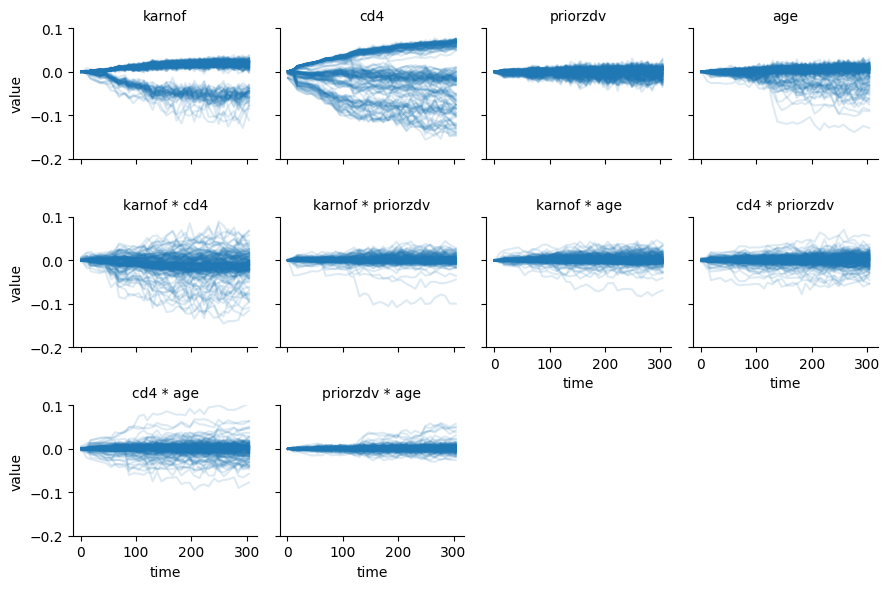

In [251]:
ax = sns.relplot(
    df_plot2, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2,
    aspect=1.125,
    col_wrap=4
    # hue="treatment", palette=sns.color_palette("tab10")
)
ax.set(ylim=(-0.2, 0.1))
# ax.fig.suptitle("SurvSHAP-IQ(t) values", y=0.97)
# sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
# plt.title(f'')
ax.set_titles(col_template="{col_name}")
plt.tight_layout()
plt.savefig(f'results/actg_order2_global.png', bbox_inches="tight")
# plt.clf()

Detailed plots

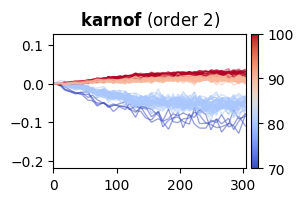

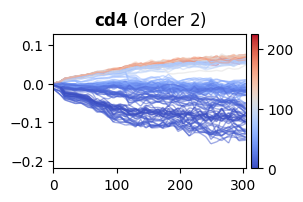

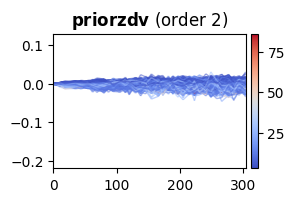

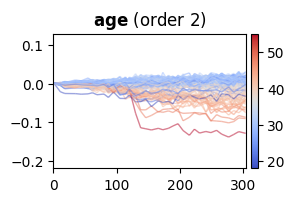

In [602]:
for feature_name in df_plot2_attribution.feature.unique():
    temp = df_plot2_attribution[df_plot2_attribution.feature == feature_name]
    fig, ax = plt.subplots(figsize=(3, 1.75))

    CMAP = "coolwarm"

    for id_val in temp.id.unique():
        line_data = temp[temp.id == id_val].sort_values(by="time")
        x = line_data["time"].values
        y = line_data["value"].values
        c = line_data["color"].values

        # Create line segments with color
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(
            segments,
            cmap=CMAP, # coolwarm
            norm=plt.Normalize(temp.color.min(), temp.color.max()),
            array=c[:-1],  # color values
            linewidth=1,
            alpha=0.5
        )
        ax.add_collection(lc)

    ax.set_xlim(0, 305)
    ax.set_ylim(-0.22, 0.13)
    ax.set_title("$\mathbf{" + feature_name + "}$ (order 2)")
    # if feature_name == "age":
    #     ax.set_xlabel('Time')
    #     ax.set_ylabel(' ')
    # if feature_name == "karnof":
    #     ax.set_xlabel('')
    #     ax.set_ylabel('Attribution')
    # if feature_name == "priorzdv":
    #     ax.set_xlabel(' ')
    #     ax.set_ylabel(' ')
    # if feature_name == "cd4":
    #     ax.set_xlabel('Time')
    #     ax.set_ylabel('Attribution')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(temp.color.quantile(0.00), temp.color.quantile(0.95), clip=True))
    sm.set_array([])  # required for colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    # cbar.set_label("color value")
    # plt.tight_layout()
    plt.savefig(f'results/actg_order2_global_{feature_name}.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()

In [521]:
palette = {
    "high * high": "#b40426",
    "high * low": "#fc8d59",
    "low * high": "#1b9e77",
    "low * low": "#3b4cc0"
}

In [531]:
X_explain.priorzdv.describe()

count    200.000000
mean      31.823750
std       31.929087
min        3.000000
25%       11.000000
50%       24.000000
75%       41.750000
max      288.000000
Name: priorzdv, dtype: float64

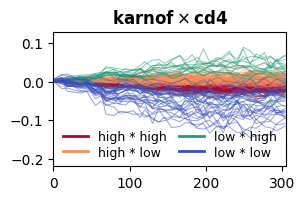

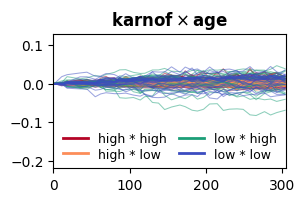

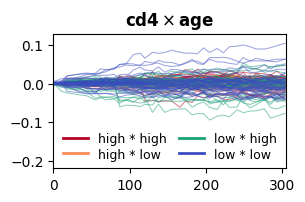

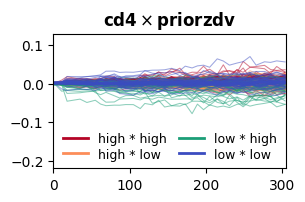

In [606]:
for feature_name in ['karnof * cd4', 'karnof * age', 'cd4 * age', 'cd4 * priorzdv']:
    temp = df_plot2_interaction[df_plot2_interaction.feature == feature_name]

    if feature_name == 'karnof * cd4':
        high_karnof = (X_explain.loc[:, "karnof"].repeat(35) >= X_explain.loc[:, "karnof"].median()) 
        high_cd4 = (X_explain.loc[:, "cd4"].repeat(35) >= 50)
        tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tcolor[high_karnof & high_cd4] = "high * high"
        tcolor[high_karnof & ~high_cd4] = "high * low"
        tcolor[~high_karnof & high_cd4] = "low * high"
        tcolor[~high_karnof & ~high_cd4] = "low * low"
        temp = temp.assign(color=tcolor)

    if feature_name == 'karnof * age':
        high_karnof = (X_explain.loc[:, "karnof"].repeat(35) >= X_explain.loc[:, "karnof"].median()) 
        high_age = (X_explain.loc[:, "age"].repeat(35) >= X_explain.loc[:, "age"].median())
        tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tcolor[high_karnof & high_age] = "high * high"
        tcolor[high_karnof & ~high_age] = "high * low"
        tcolor[~high_karnof & high_age] = "low * high"
        tcolor[~high_karnof & ~high_age] = "low * low"
        temp = temp.assign(color=tcolor)

    if feature_name == 'cd4 * age':
        high_cd4 = (X_explain.loc[:, "cd4"].repeat(35) >= 50)
        high_age = (X_explain.loc[:, "age"].repeat(35) >= X_explain.loc[:, "age"].median())
        tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tcolor[high_cd4 & high_age] = "high * high"
        tcolor[high_cd4 & ~high_age] = "high * low"
        tcolor[~high_cd4 & high_age] = "low * high"
        tcolor[~high_cd4 & ~high_age] = "low * low"
        temp = temp.assign(color=tcolor)

    if feature_name == 'cd4 * priorzdv':
        high_cd4 = (X_explain.loc[:, "cd4"].repeat(35) >= 50)
        high_priorzdv = (X_explain.loc[:, "priorzdv"].repeat(35) >= X_explain.loc[:, "priorzdv"].median())
        tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tcolor[high_cd4 & high_priorzdv] = "high * high"
        tcolor[high_cd4 & ~high_priorzdv] = "high * low"
        tcolor[~high_cd4 & high_priorzdv] = "low * high"
        tcolor[~high_cd4 & ~high_priorzdv] = "low * low"
        temp = temp.assign(color=tcolor)

    fig, ax = plt.subplots(figsize=(3, 1.75))

    for group, group_data in temp.groupby("color"):
        for id_val in group_data.id.unique():
            line_data = group_data[group_data.id == id_val].sort_values("time")
            x = line_data["time"].values
            y = line_data["value"].values
            ax.plot(x, y, color=palette[group], alpha=0.5, linewidth=0.75)

    ax.set_xlim(0, 305)
    ax.set_ylim(-0.22, 0.13)
    feat1 = feature_name.split(" * ")[0]
    feat2 = feature_name.split(" * ")[1]
    ax.set_title("$\mathbf{" + feat1 + "} \\times \mathbf{" + feat2 + "}$")

    # Label setup
    # if feature_name == "karnof * cd4":
    #     ax.set_xlabel('Time')
    #     ax.set_ylabel('Attribution')
    # if feature_name == "cd4 * priorzdv":
    #     ax.set_xlabel('Time')
    #     ax.set_ylabel(' ')

    # Add legend
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=label) for label, color in palette.items()]
    ax.legend(
        handles=handles, 
        loc="upper center",
        bbox_to_anchor=(0.5, 0.35),  # Adjust position below plot
        ncol=2,  # Spread out horizontally
        frameon=False,
        fontsize=9,
        columnspacing=1,
        labelspacing=0.2
    )

    # Save
    plt.savefig(f'results/actg_order2_global_{feature_name.replace(" * ", "-")}_v1.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()

In [545]:
style_map = {
    "70": "solid",
    "80": "dashed",
    "90": "dotted",
    "100": (0, (3, 1, 1, 1)),  # dash-dot
    "high": "solid",
    "low": "dashed"
}

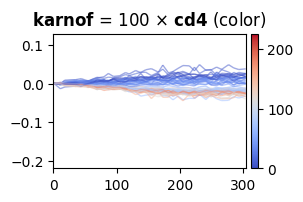

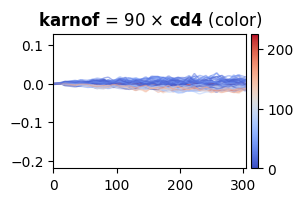

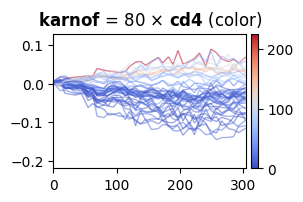

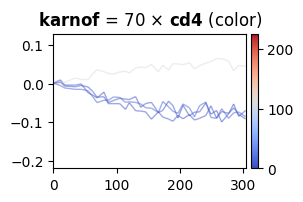

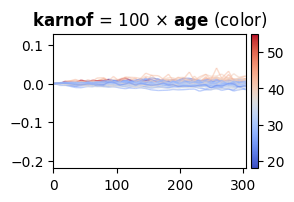

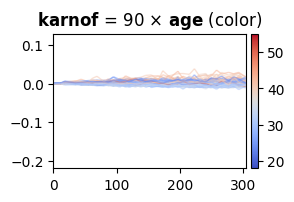

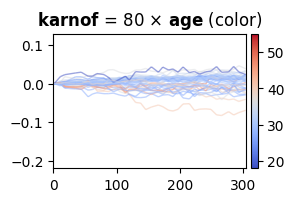

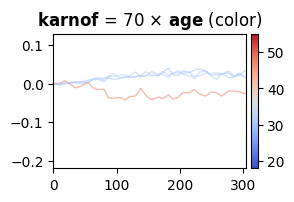

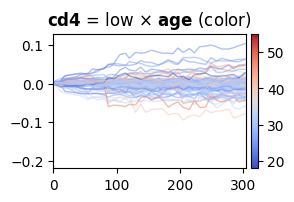

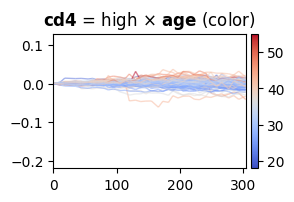

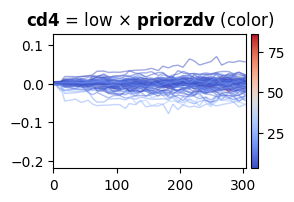

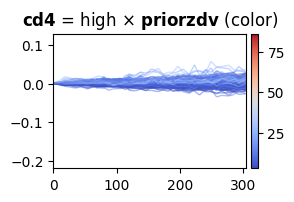

In [608]:
for feature_name in ['karnof * cd4', 'karnof * age', 'cd4 * age', 'cd4 * priorzdv']:
    temp = df_plot2_interaction[df_plot2_interaction.feature == feature_name]

    if feature_name == 'karnof * cd4' or feature_name == 'karnof * age':
        tstyle = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tstyle[X_explain.loc[:, "karnof"].repeat(35) == 70] = "70"
        tstyle[X_explain.loc[:, "karnof"].repeat(35) == 80] = "80"
        tstyle[X_explain.loc[:, "karnof"].repeat(35) == 90] = "90"
        tstyle[X_explain.loc[:, "karnof"].repeat(35) == 100] = "100"
        temp = temp.assign(style=tstyle, color=X_explain.loc[:, feature_name.replace("karnof * ", "")].repeat(35).values)

    if feature_name == 'cd4 * age' or feature_name == 'cd4 * priorzdv':
        tstyle = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tstyle[X_explain.loc[:, "cd4"].repeat(35) > 50] = "high"
        tstyle[X_explain.loc[:, "cd4"].repeat(35) <= 50] = "low"
        temp = temp.assign(style=tstyle, color=X_explain.loc[:, feature_name.replace("cd4 * ", "")].repeat(35).values)

    
    for style in temp['style'].unique():
        temp2 = temp.loc[temp['style'] == style, :]
        fig, ax = plt.subplots(figsize=(3, 1.75))

        CMAP = "coolwarm"

        for id_val in temp.id.unique():
            line_data = temp2[temp2.id == id_val].sort_values(by="time")
            x = line_data["time"].values
            y = line_data["value"].values
            c = line_data["color"].values

            # Create line segments with color
            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(
                segments,
                cmap=CMAP, # coolwarm
                norm=plt.Normalize(temp.color.min(), temp.color.max()),
                array=c[:-1],  # color values
                linewidth=1,
                alpha=0.5
            )
            ax.add_collection(lc)

        ax.set_xlim(0, 305)
        ax.set_ylim(-0.22, 0.13)
        feat1 = feature_name.split(" * ")[0]
        feat2 = feature_name.split(" * ")[1]
        ax.set_title("$\mathbf{" + feat1 + "}$ = " + style + " $\\times$ $\mathbf{" + feat2 + "}$ (color)")

        # ax.set_xlabel('Time')
        # if feature_name == "age":
        #     ax.set_xlabel('Time')
        #     ax.set_ylabel(' ')
        # if feature_name == "karnof":
        #     ax.set_xlabel(' ')
        #     ax.set_ylabel('Attribution')
        # if feature_name == "priorzdv":
        #     ax.set_xlabel(' ')
        #     ax.set_ylabel(' ')
        # if feature_name == "cd4":
        #     ax.set_xlabel('Time')
        #     ax.set_ylabel('Attribution')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(temp.color.quantile(0.00), temp.color.quantile(0.95), clip=True))
        sm.set_array([])  # required for colorbar
        cbar = fig.colorbar(sm, ax=ax, pad=0.02)
        # cbar.set_label("color value")
        # plt.tight_layout()
        ttitle = f'{feat1} = {style} | {feat2} (color)'
        plt.savefig(f'results/actg_order2_global_{ttitle.replace(" ", "-")}_v2.pdf', bbox_inches="tight", pad_inches=0.01)
        # plt.close()